# EMS for EREV-Platoon based on MADDPG

## 1. Import libraries

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from tqdm import tqdm   
import matplotlib.pyplot as plt
import time, os
import numpy as np
import scipy.io as scio
from numpy import mat
from collections import deque
from scipy.io import savemat
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['CUDA_VISIBLE_DEVICES']= '0,1'

In [2]:
def plot1(data1, data2, data3, data4 ,data5 ):
    x = np.arange(0, len(data1), 1)
    y1 = data1;     y2 = data2;     y3 = data3;   y4 = data4;  y5 = data5;  
    plt.plot(x, y1, color='skyblue', label='vehicle1');     plt.plot(x, y2, color='yellow',  label='vehicle2');
    plt.plot(x, y3, color='red',     label='vehicle3');    plt.plot(x, y4, color='green',      label='vehicle4');    
    plt.plot(x, y5, color='black',   label='vehicle5');     
    plt.legend();    plt.show();  
    
def plot2(data1, data2, data3, data4 , data5):
    x = np.arange(0, len(data1), 1)
    y1 = data1;     y2 = data2;     y3 = data3;   y4 = data4;  y5 = data5; 
    plt.subplot(231);      plt.plot(x, y1, color='skyblue',  label='vehicle1');     plt.subplot(232);      plt.plot(x, y2, color='yellow',   label='vehicle2');
    plt.subplot(233);      plt.plot(x, y3, color='red',         label='vehicle3');    plt.subplot(234);      plt.plot(x, y4, color='green',   label='vehicle4');
    plt.subplot(235);      plt.plot(x, y5, color='black',   label='vehicle5');   
    plt.legend();    plt.show();      

## 2. Driving cycle

In [3]:
data_path = 'Data/PLF_DMPC_FTP75.mat'  
data = scio.loadmat(data_path) 
data.keys()   

dict_keys(['__header__', '__version__', '__globals__', 'A', 'Acc', 'AccMax', 'AccMin', 'Aeq', 'Ca', 'Cost', 'Eta', 'Exitflg', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5', 'Mass', 'Np', 'Num_step', 'Num_veh', 'PL', 'Pa', 'Pa_next', 'Pd', 'Pnp', 'Postion', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'R', 'R1', 'R2', 'R3', 'R4', 'R5', 'T', 'T_plot', 'Ta', 'Tao', 'Temp', 'Tim_step', 'Time_sim', 'Tnp', 'Torque', 'Torquebound', 'U', 'Va', 'Va_next', 'Vd', 'Vehicle_Type', 'Velocity', 'Vend', 'Vnp', 'X0', 'Xa', 'Xdes', 'Xend', 'Xnba', 'Xnfa', 'b', 'beq', 'd', 'd12', 'd23', 'd34', 'd45', 'f', 'g', 'None', 'i', 'j', 'lb', 'options', 'output', 'speed_vector', 't', 'tol_opt', 'u', 'u0', 'ua', 'ua_next', 'ub', 'v0', 'x0', '__function_workspace__'])

In [4]:
carSpeed = data['Velocity'];   carTorque  = data['Torque'];   # 车速：Velocity  转矩：Torque
# 车速 
Velocity1 = carSpeed[:,0];   Velocity2 = carSpeed[:,1];   Velocity3 = carSpeed[:,2];
Velocity4 = carSpeed[:,3];   Velocity5 = carSpeed[:,4];
# 转矩
Torque1 = carTorque[:,0]; Torque2 = carTorque[:,1]; Torque3 = carTorque[:,2];
Torque4 = carTorque[:,3]; Torque5 = carTorque[:,4];

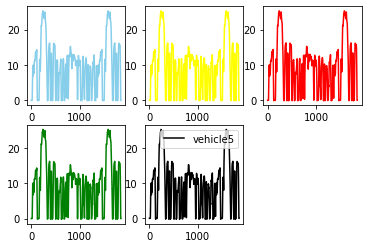

In [5]:
# 车速
plot2(Velocity1.T, Velocity2.T, Velocity3.T, Velocity4.T, Velocity5.T)

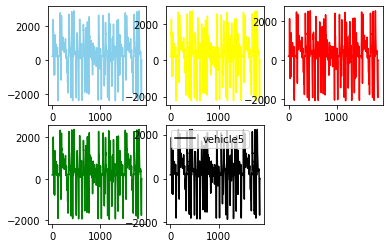

In [6]:
# 转矩
plot2(Torque1, Torque2, Torque3,Torque4, Torque5)

In [7]:
speed_max =  np.max([np.max(Velocity1),np.max(Velocity2),np.max(Velocity3),
                     np.max(Velocity4),np.max(Velocity5)])
Torque_max = np.max([np.max(Torque1),np.max(Torque2),np.max(Torque3),
                     np.max(Torque4),np.max(Torque5)])
Torque_min = np.min([np.min(Torque1),np.min(Torque2),np.min(Torque3),
                     np.min(Torque4),np.min(Torque5)])
total_milage = (np.sum(Velocity1) + np.sum(Velocity2) + np.sum(Velocity3)+
                np.sum(Velocity4) + np.sum(Velocity5) ) / 1000 / 6
print ( '最大车速:', speed_max, '最大转矩:', Torque_max, '最小转矩:', Torque_min,'总里程:', total_milage)

最大车速: 25.329832497579453 最大转矩: 2901.007585556707 最小转矩: -2378.5321623879136 总里程: 14.802953653761769


## 3. Agent initialization

In [8]:
# 一个循环最终SOC
SOC1_final_list=[]; SOC2_final_list=[]; SOC3_final_list=[]; SOC4_final_list=[]; SOC5_final_list=[];
# 一个循环油钱
Total_fuel_RMB1_list=[]; Total_fuel_RMB2_list=[]; Total_fuel_RMB3_list=[]; Total_fuel_RMB4_list=[]; Total_fuel_RMB5_list=[]; 
# 一个循环电钱
Total_elec_RMB1_list=[]; Total_elec_RMB2_list=[]; Total_elec_RMB3_list=[]; Total_elec_RMB4_list=[]; Total_elec_RMB5_list=[]; 
# 一个循环花钱
Total_RMB1_list=[]; Total_RMB2_list=[]; Total_RMB3_list=[]; Total_RMB4_list=[]; Total_RMB5_list=[];        
# 百公里燃油消耗
Total_fuel1_100Km_list=[]; Total_fuel2_100Km_list=[]; Total_fuel3_100Km_list=[]; Total_fuel4_100Km_list=[]; Total_fuel5_100Km_list=[]; 
# 一个循环奖励
reward1_all_list=[]; reward2_all_list=[]; reward3_all_list=[]; reward4_all_list=[]; reward5_all_list=[];
# 平均奖励
mean_reward1_list=[]; mean_reward2_list=[]; mean_reward3_list=[]; mean_reward4_list=[]; mean_reward5_list=[]; 
# 偶数循环平均奖励
list_even1=[]; list_even2=[]; list_even3=[]; list_even4=[]; list_even5=[];  
# 奇数循环平均奖励
list_odd1=[]; list_odd2=[]; list_odd3=[]; list_odd4=[]; list_odd5=[]; 
# 平均奖励递减
mean_discrepancy1_list=[]; mean_discrepancy2_list=[]; mean_discrepancy3_list=[]; mean_discrepancy4_list=[]; mean_discrepancy5_list=[]; 

In [9]:
# Import EREV model
from EREV_model import EREV
EREV = EREV()

In [10]:
# Import DDPG agent
from MADDPG import MADDPG;     
state_size = 3   # 状态维度
action_size = 1  # 动作维度
num_agents = 5   # 智能体数目
random_seed = 9
maddpg = MADDPG(state_size, action_size, num_agents, random_seed) # MADDPG

In [11]:
SOC_origin = 0.65; step_episode = 0; n_episodes = 10; 

## 4. Run

100%|█████████████████████████████████████████████████████████████████████████████▊| 1850/1853 [01:06<00:00, 31.65it/s]

循环次数: 1
燃油消耗L (1.8454875583265744, 1.8384966219992005, 1.8362809882446707, 1.7694925857990915, 1.834235667321367): 百公里燃油消耗L ([12.467022470597236], [12.41979583940666], [12.404828328149428], [11.953645381774352], [12.391011349652139]): 最终SOC (0.4358283425693011, 0.4798662212794527, 0.5202162789540883, 0.5190291753800844, 0.595016102892574):


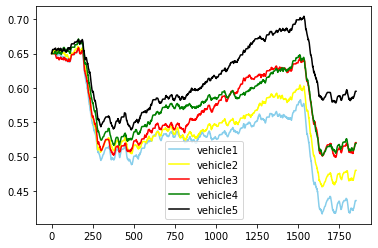

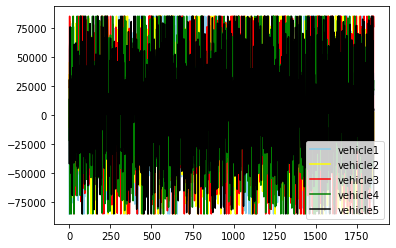

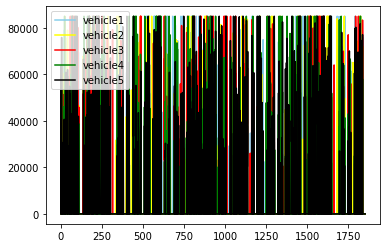

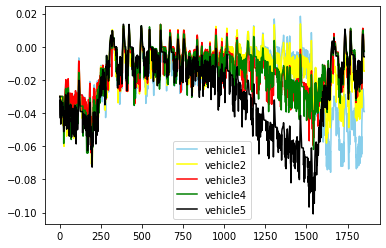

100%|█████████████████████████████████████████████████████████████████████████████▉| 1852/1853 [01:04<00:00, 30.10it/s]

循环次数: 2
燃油消耗L (1.7562774151732419, 1.7791723284152696, 1.8617228626449784, 1.7043983604187005, 1.888739676985971): 百公里燃油消耗L ([12.467022470597236, 11.864371504851206], [12.41979583940666, 12.01903599801612], [12.404828328149428, 12.576698584554928], [11.953645381774352, 11.51390729366753], [12.391011349652139, 12.759208203735739]): 最终SOC (0.379580370847895, 0.4378818467253871, 0.5303659758480103, 0.47854479520868753, 0.6178631604320179):


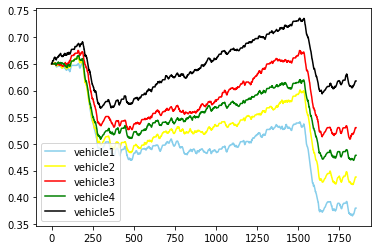

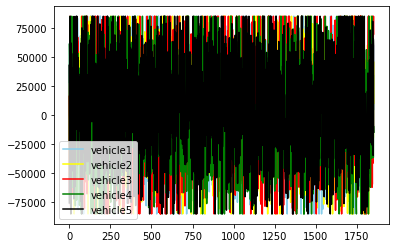

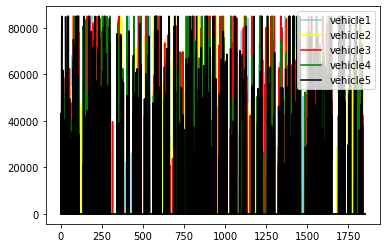

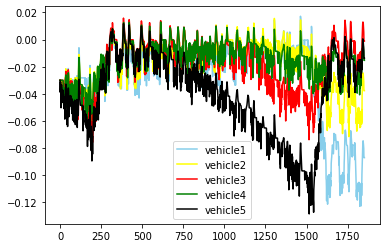

100%|█████████████████████████████████████████████████████████████████████████████▉| 1851/1853 [01:04<00:00, 28.07it/s]

循环次数: 3
燃油消耗L (1.8280036359881329, 1.8691942348821884, 1.7670843133542997, 1.8063550105901702, 1.7241716559805107): 百公里燃油消耗L ([12.467022470597236, 11.864371504851206, 12.348911431764128], [12.41979583940666, 12.01903599801612, 12.627170756608992], [12.404828328149428, 12.576698584554928, 11.93737651745767], [11.953645381774352, 11.51390729366753, 12.202666122183894], [12.391011349652139, 12.759208203735739, 11.647483983997743]): 最终SOC (0.4245470815407693, 0.4963732103215186, 0.4772287850239703, 0.5416185037900392, 0.5275928938538459):


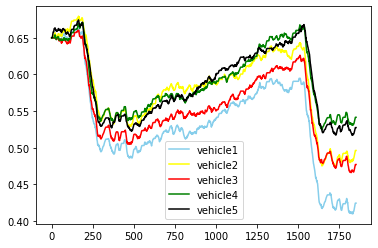

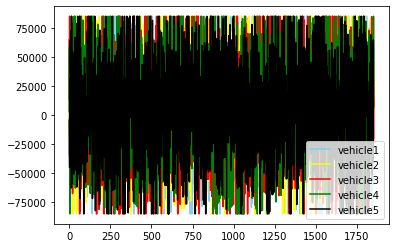

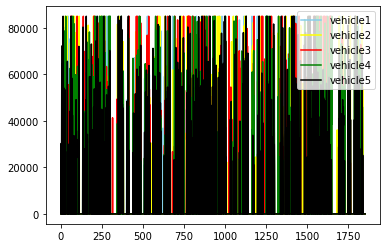

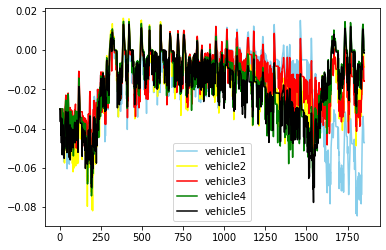

100%|█████████████████████████████████████████████████████████████████████████████▉| 1852/1853 [19:17<00:00,  1.73it/s]

循环次数: 4
燃油消耗L (1.123682845983384, 1.1169287047699914, 1.0226348166771813, 0.9907688214313071, 0.976288991231812): 百公里燃油消耗L ([12.467022470597236, 11.864371504851206, 12.348911431764128, 7.590936729696716], [12.41979583940666, 12.01903599801612, 12.627170756608992, 7.545309746248879], [12.404828328149428, 12.576698584554928, 11.93737651745767, 6.908316006362057], [11.953645381774352, 11.51390729366753, 12.202666122183894, 6.69304818893039], [12.391011349652139, 12.759208203735739, 11.647483983997743, 6.59523101988308]): 最终SOC (-0.20067272712994993, -0.09148502781561821, -0.09905870698811989, -0.04923412285668612, 0.005534813302764452):


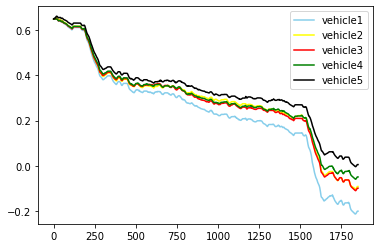

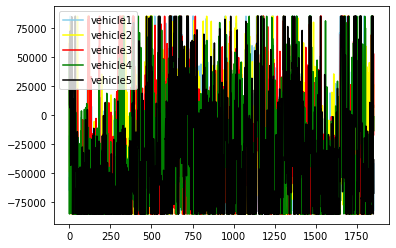

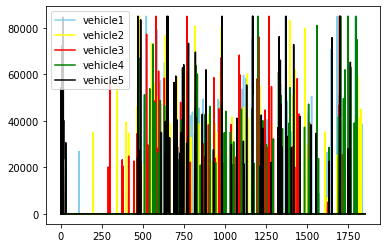

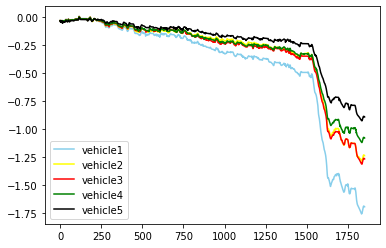

100%|█████████████████████████████████████████████████████████████████████████████▉| 1852/1853 [18:32<00:00,  1.73it/s]

循环次数: 5
燃油消耗L (1.4230568938479706, 1.7334007495090251, 1.081807782153308, 1.7048234187499767, 1.2310969907961067): 百公里燃油消耗L ([12.467022470597236, 11.864371504851206, 12.348911431764128, 7.590936729696716, 9.61333073880387], [12.41979583940666, 12.01903599801612, 12.627170756608992, 7.545309746248879, 11.70983028152985], [12.404828328149428, 12.576698584554928, 11.93737651745767, 6.908316006362057, 7.30805356455599], [11.953645381774352, 11.51390729366753, 12.202666122183894, 6.69304818893039, 11.51677873636213], [12.391011349652139, 12.759208203735739, 11.647483983997743, 6.59523101988308, 8.316563164292937]): 最终SOC (0.12384490403701494, 0.4217905022917453, -0.021880432977677267, 0.4392838252487693, 0.19334817504445248):


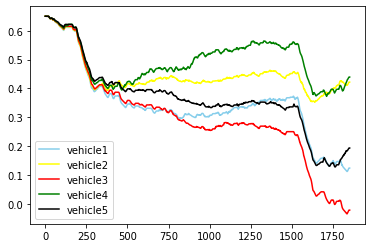

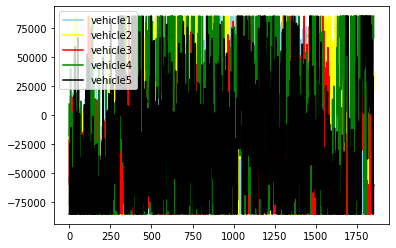

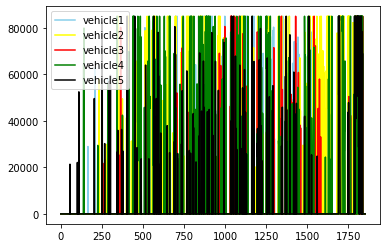

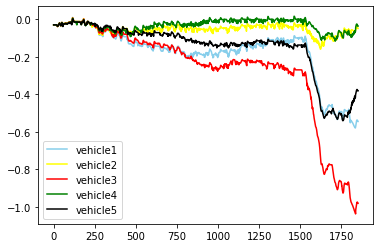

100%|█████████████████████████████████████████████████████████████████████████████▉| 1852/1853 [19:51<00:00,  1.67it/s]

循环次数: 6
燃油消耗L (1.5480446854242498, 1.726487309078609, 1.7901927406102836, 1.681942335683276, 1.2786923240450432): 百公里燃油消耗L ([12.467022470597236, 11.864371504851206, 12.348911431764128, 7.590936729696716, 9.61333073880387, 10.457674337383716], [12.41979583940666, 12.01903599801612, 12.627170756608992, 7.545309746248879, 11.70983028152985, 11.663127166785861], [12.404828328149428, 12.576698584554928, 11.93737651745767, 6.908316006362057, 7.30805356455599, 12.093483385022655], [11.953645381774352, 11.51390729366753, 12.202666122183894, 6.69304818893039, 11.51677873636213, 11.362207671682171], [12.391011349652139, 12.759208203735739, 11.647483983997743, 6.59523101988308, 8.316563164292937, 8.638089086498614]): 最终SOC (0.21489979574143467, 0.4124467794628889, 0.47098685653228706, 0.4226777217683397, 0.2636077317472247):


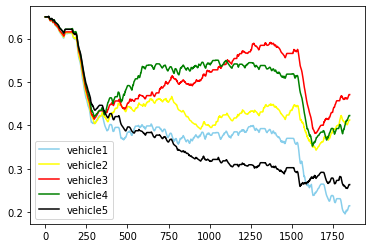

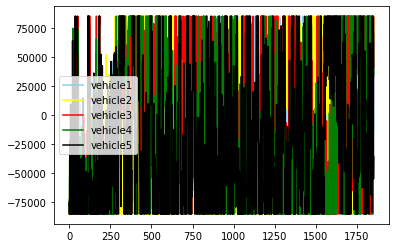

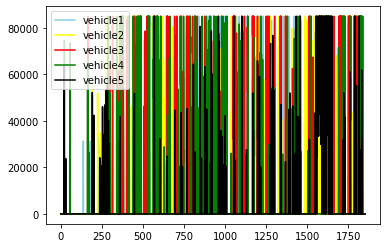

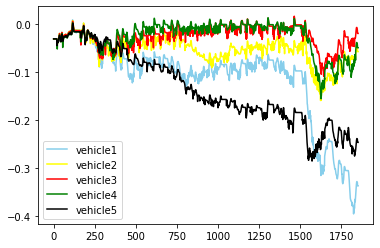

100%|█████████████████████████████████████████████████████████████████████████████▉| 1852/1853 [18:18<00:00,  1.73it/s]

循环次数: 7
燃油消耗L (1.588133574563987, 1.7047773746576604, 1.8392510060939538, 1.574798063428402, 1.5943002512223672): 百公里燃油消耗L ([12.467022470597236, 11.864371504851206, 12.348911431764128, 7.590936729696716, 9.61333073880387, 10.457674337383716, 10.728491162710666], [12.41979583940666, 12.01903599801612, 12.627170756608992, 7.545309746248879, 11.70983028152985, 11.663127166785861, 11.51646768970622], [12.404828328149428, 12.576698584554928, 11.93737651745767, 6.908316006362057, 7.30805356455599, 12.093483385022655, 12.424892012186756], [11.953645381774352, 11.51390729366753, 12.202666122183894, 6.69304818893039, 11.51677873636213, 11.362207671682171, 10.638404336476523], [12.391011349652139, 12.759208203735739, 11.647483983997743, 6.59523101988308, 8.316563164292937, 8.638089086498614, 10.770149583067964]): 最终SOC (0.2317879640416893, 0.3923579491690364, 0.514648590831598, 0.35872891792037975, 0.41983752861560597):


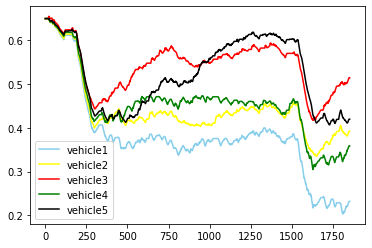

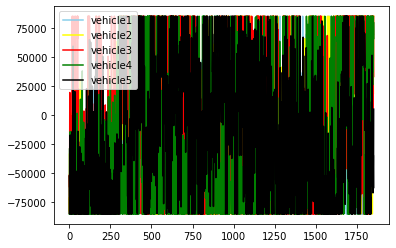

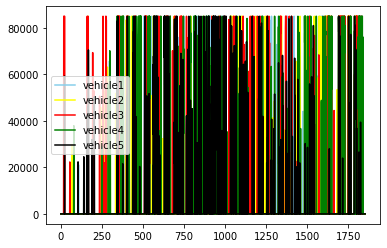

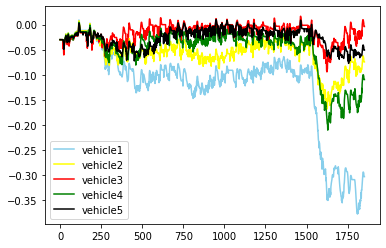

100%|█████████████████████████████████████████████████████████████████████████████▉| 1852/1853 [18:22<00:00,  1.60it/s]

循环次数: 8
燃油消耗L (1.7552569615229698, 1.709208576439979, 1.8779006830943723, 1.4662418526536403, 1.645933338666984): 百公里燃油消耗L ([12.467022470597236, 11.864371504851206, 12.348911431764128, 7.590936729696716, 9.61333073880387, 10.457674337383716, 10.728491162710666, 11.857477923515074], [12.41979583940666, 12.01903599801612, 12.627170756608992, 7.545309746248879, 11.70983028152985, 11.663127166785861, 11.51646768970622, 11.546402268209695], [12.404828328149428, 12.576698584554928, 11.93737651745767, 6.908316006362057, 7.30805356455599, 12.093483385022655, 12.424892012186756, 12.68598637149117], [11.953645381774352, 11.51390729366753, 12.202666122183894, 6.69304818893039, 11.51677873636213, 11.362207671682171, 10.638404336476523, 9.905062779690827], [12.391011349652139, 12.759208203735739, 11.647483983997743, 6.59523101988308, 8.316563164292937, 8.638089086498614, 10.770149583067964, 11.118952184577804]): 最终SOC (0.3173273903596357, 0.4102258219531766, 0.5309991088353742, 0.286293789156624, 0

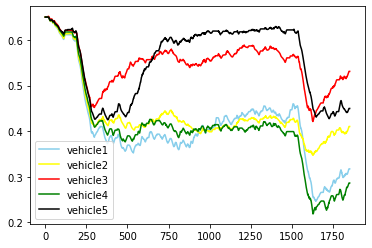

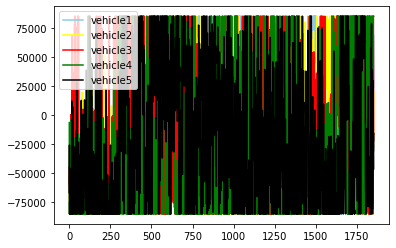

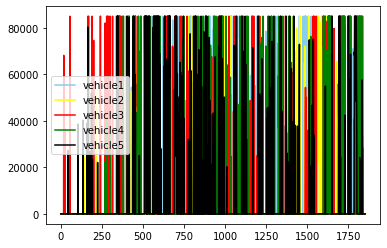

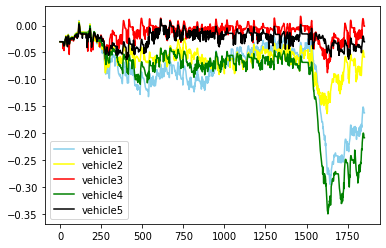

100%|█████████████████████████████████████████████████████████████████████████████▉| 1852/1853 [19:40<00:00,  1.59it/s]

循环次数: 9
燃油消耗L (1.6573889055095508, 1.6603844403476575, 1.8263649815951875, 1.697539842235997, 1.627547958280962): 百公里燃油消耗L ([12.467022470597236, 11.864371504851206, 12.348911431764128, 7.590936729696716, 9.61333073880387, 10.457674337383716, 10.728491162710666, 11.857477923515074, 11.196339219020457], [12.41979583940666, 12.01903599801612, 12.627170756608992, 7.545309746248879, 11.70983028152985, 11.663127166785861, 11.51646768970622, 11.546402268209695, 11.216575280742813], [12.404828328149428, 12.576698584554928, 11.93737651745767, 6.908316006362057, 7.30805356455599, 12.093483385022655, 12.424892012186756, 12.68598637149117, 12.337841651831871], [11.953645381774352, 11.51390729366753, 12.202666122183894, 6.69304818893039, 11.51677873636213, 11.362207671682171, 10.638404336476523, 9.905062779690827, 11.467575201146518], [12.391011349652139, 12.759208203735739, 11.647483983997743, 6.59523101988308, 8.316563164292937, 8.638089086498614, 10.770149583067964, 11.118952184577804, 10.994751

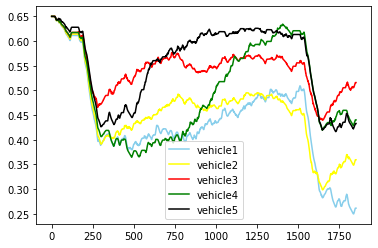

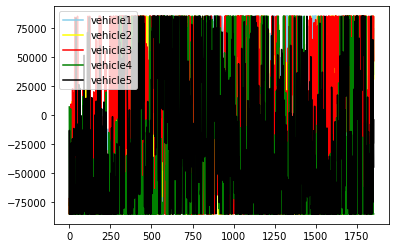

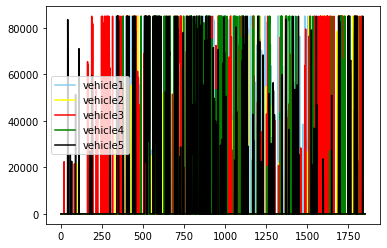

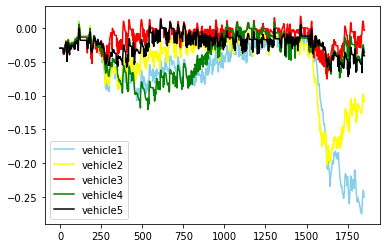

100%|█████████████████████████████████████████████████████████████████████████████▉| 1852/1853 [18:46<00:00,  1.65it/s]

循环次数: 10
燃油消耗L (1.583853275912681, 1.633386051088773, 1.8051256746089384, 2.1290589031535707, 1.6989173669106503): 百公里燃油消耗L ([12.467022470597236, 11.864371504851206, 12.348911431764128, 7.590936729696716, 9.61333073880387, 10.457674337383716, 10.728491162710666, 11.857477923515074, 11.196339219020457, 10.699575996511937], [12.41979583940666, 12.01903599801612, 12.627170756608992, 7.545309746248879, 11.70983028152985, 11.663127166785861, 11.51646768970622, 11.546402268209695, 11.216575280742813, 11.034190130519608], [12.404828328149428, 12.576698584554928, 11.93737651745767, 6.908316006362057, 7.30805356455599, 12.093483385022655, 12.424892012186756, 12.68598637149117, 12.337841651831871, 12.194361455358706], [11.953645381774352, 11.51390729366753, 12.202666122183894, 6.69304818893039, 11.51677873636213, 11.362207671682171, 10.638404336476523, 9.905062779690827, 11.467575201146518, 14.382662764147263], [12.391011349652139, 12.759208203735739, 11.647483983997743, 6.59523101988308, 8.3165

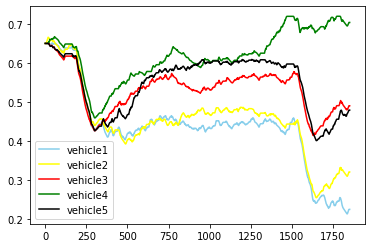

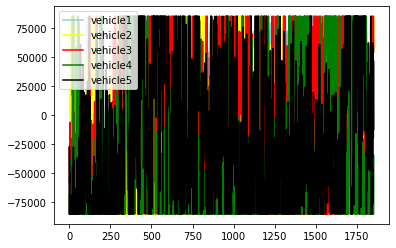

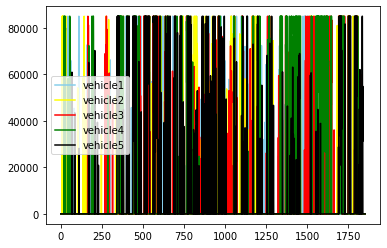

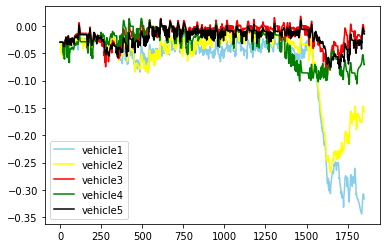

100%|██████████████████████████████████████████████████████████████████████████████| 1853/1853 [18:48<00:00,  1.64it/s]


In [12]:
for i_episode in range(1, n_episodes+1):
    # 状态输入
    SOC1 = SOC_origin; SOC2 = SOC_origin; SOC3 = SOC_origin; SOC4 = SOC_origin; SOC5 = SOC_origin; 
    T1 = Torque1[0];  T2 = Torque2[0];  T3 = Torque3[0];T4 = Torque4[0];  T5 = Torque5[0]; 
    V1 = Velocity1[0]; V2 = Velocity2[0]; V3 = Velocity3[0]; V4 = Velocity4[0]; V5 = Velocity5[0];

    # 状态空间 v、T、SOC
    V = np.vstack((V1, V2, V3, V4, V5));
    T = np.vstack((T1, T2, T3, T4, T5));
    SOC = np.vstack((SOC1,SOC2,SOC3,SOC4,SOC5));
    states = np.concatenate((V,  T,  SOC),axis=1)   

    # 车辆
    P_axle1 = 0;   T_axle1 = 0;   W_axle1 = 0;   P_axle1_list = [];   T_axle1_list = [];   W_axle1_list = [];
    P_axle2 = 0;   T_axle2 = 0;   W_axle2 = 0;   P_axle2_list = [];   T_axle2_list = [];   W_axle2_list = [];
    P_axle3 = 0;   T_axle3 = 0;   W_axle3 = 0;   P_axle3_list = [];   T_axle3_list = [];   W_axle3_list = [];
    P_axle4 = 0;   T_axle4 = 0;   W_axle4 = 0;   P_axle4_list = [];   T_axle4_list = [];   W_axle4_list = [];
    P_axle5 = 0;   T_axle5 = 0;   W_axle5 = 0;   P_axle5_list = [];   T_axle5_list = [];   W_axle5_list = [];
    # 驱动电机
    P_mot1 = 0; P_mot1_list = []; T_mot1 = 0; T_mot1_list = []; W_mot1 = 0; W_mot1_list = []; eff_m1 = 0; eff_m1_list = [];
    P_mot2 = 0; P_mot2_list = []; T_mot2 = 0; T_mot2_list = []; W_mot2 = 0; W_mot2_list = []; eff_m2 = 0; eff_m2_list = [];
    P_mot3 = 0; P_mot3_list = []; T_mot3 = 0; T_mot3_list = []; W_mot3 = 0; W_mot3_list = []; eff_m3 = 0; eff_m3_list = [];
    P_mot4 = 0; P_mot4_list = []; T_mot4 = 0; T_mot4_list = []; W_mot4 = 0; W_mot4_list = []; eff_m4 = 0; eff_m4_list = [];
    P_mot5 = 0; P_mot5_list = []; T_mot5 = 0; T_mot5_list = []; W_mot5 = 0; W_mot5_list = []; eff_m5 = 0; eff_m5_list = [];
    # 发动机
    P_eng1 = 0; P_eng1_list = []; T_eng1 = 0; T_eng1_list = []; W_eng1 = 0; W_eng1_list = []; eff_e1 = 0; eff_e1_list = [];
    P_eng2 = 0; P_eng2_list = []; T_eng2 = 0; T_eng2_list = []; W_eng2 = 0; W_eng2_list = []; eff_e2 = 0; eff_e2_list = [];
    P_eng3 = 0; P_eng3_list = []; T_eng3 = 0; T_eng3_list = []; W_eng3 = 0; W_eng3_list = []; eff_e3 = 0; eff_e3_list = [];
    P_eng4 = 0; P_eng4_list = []; T_eng4 = 0; T_eng4_list = []; W_eng4 = 0; W_eng4_list = []; eff_e4 = 0; eff_e4_list = [];
    P_eng5 = 0; P_eng5_list = []; T_eng5 = 0; T_eng5_list = []; W_eng5 = 0; W_eng5_list = []; eff_e5 = 0; eff_e5_list = [];
    # 发电机
    P_gen1 = 0; P_gen1_list = []; T_gen1 = 0; T_gen1_list = []; W_gen1 = 0; W_gen1_list = []; eff_g1 = 0; eff_g1_list = [];
    P_gen2 = 0; P_gen2_list = []; T_gen2 = 0; T_gen2_list = []; W_gen2 = 0; W_gen2_list = []; eff_g2 = 0; eff_g2_list = [];
    P_gen3 = 0; P_gen3_list = []; T_gen3 = 0; T_gen3_list = []; W_gen3 = 0; W_gen3_list = []; eff_g3 = 0; eff_g3_list = [];
    P_gen4 = 0; P_gen4_list = []; T_gen4 = 0; T_gen4_list = []; W_gen4 = 0; W_gen4_list = []; eff_g4 = 0; eff_g4_list = [];
    P_gen5 = 0; P_gen5_list = []; T_gen5 = 0; T_gen5_list = []; W_gen5 = 0; W_gen5_list = []; eff_g5 = 0; eff_g5_list = [];
    # 电池
    SOC1_data = [];    P_batt1 = 0;   P_batt1_list = [];
    SOC2_data = [];    P_batt2 = 0;   P_batt2_list = [];
    SOC3_data = [];    P_batt3 = 0;   P_batt3_list = [];
    SOC4_data = [];    P_batt4 = 0;   P_batt4_list = [];
    SOC5_data = [];    P_batt5 = 0;   P_batt5_list = [];
    
    # 动作 
    a1 = 0; a1_list = []; act1 = 0; act1_list = []; action1 = 0; action1_list = []; Eng_pwr_opt1 = 0; Eng_pwr_opt1_list = [];   
    a2 = 0; a2_list = []; act2 = 0; act2_list = []; action2 = 0; action2_list = []; Eng_pwr_opt2 = 0; Eng_pwr_opt2_list = [];   
    a3 = 0; a3_list = []; act3 = 0; act3_list = []; action3 = 0; action3_list = []; Eng_pwr_opt3 = 0; Eng_pwr_opt3_list = [];   
    a4 = 0; a4_list = []; act4 = 0; act4_list = []; action4 = 0; action4_list = []; Eng_pwr_opt4 = 0; Eng_pwr_opt4_list = [];   
    a5 = 0; a5_list = []; act5 = 0; act5_list = []; action5 = 0; action5_list = []; Eng_pwr_opt5 = 0; Eng_pwr_opt5_list = [];   
    # 奖励
    mean_reward1 = 0;  mean_reward2 = 0;   mean_reward3 = 0; mean_reward4 = 0;   mean_reward5 = 0;   
    ep_reward1_all = 0;  ep_reward2_all = 0;  ep_reward3_all = 0;  ep_reward4_all = 0;  ep_reward5_all = 0;  
    r1_list = [];  r2_list = [];  r3_list = [];  r4_list = [];  r5_list = [];  

    # 钱
    fuel1 = 0;   fuel1_list=[];   Total_fuel1_RMB = 0;   elec1 = 0;   elec1_list=[];   Total_elec1_RMB = 0;
    Total_RMB_cost1 = 0;   RMB_cost1_list = [];   RMB_cost1 = 0;   Total_fuel1  = 0;  
    fuel2 = 0;   fuel2_list=[];   Total_fuel2_RMB = 0;   elec2 = 0;   elec2_list=[];   Total_elec2_RMB = 0;
    Total_RMB_cost2 = 0;   RMB_cost2_list = [];   RMB_cost2 = 0;   Total_fuel2  = 0;  
    fuel3 = 0;   fuel3_list=[];   Total_fuel3_RMB = 0;   elec3 = 0;   elec3_list=[];   Total_elec3_RMB = 0;
    Total_RMB_cost3 = 0;   RMB_cost3_list = [];   RMB_cost3 = 0;   Total_fuel3  = 0;  
    fuel4 = 0;   fuel4_list=[];   Total_fuel4_RMB = 0;   elec4 = 0;   elec4_list=[];   Total_elec4_RMB = 0;
    Total_RMB_cost4 = 0;   RMB_cost4_list = [];   RMB_cost4 = 0;   Total_fuel4  = 0;  
    fuel5 = 0;   fuel5_list=[];   Total_fuel5_RMB = 0;   elec5 = 0;   elec5_list=[];   Total_elec5_RMB = 0;
    Total_RMB_cost5 = 0;   RMB_cost5_list = [];   RMB_cost5 = 0;   Total_fuel5  = 0;  
    
    Total_fuel = ();  Total_fuel_100Km = ();  SOC_final = ();  Eng_pwr_opt_max = 85000;
    step_episode += 1;      dones = [False, False, False, False, False] ;  not_done = 1

    for t in tqdm(range(len(Velocity1) - 1)): 

        # 选择动作
        actions = maddpg.act(states, i_episode, add_noise=True);  
        action1 = actions[0]; action2 = actions[1]; action3 = actions[2]; action4 = actions[3]; action5 = actions[4];
        # 动作列表
        action1_list.append(action1); action2_list.append(action2); action3_list.append(action3);  
        action4_list.append(action4); action5_list.append(action5);  
        # 发动机工作点
        Eng_pwr_opt1 = action1 * Eng_pwr_opt_max; Eng_pwr_opt2 = action2 * Eng_pwr_opt_max; Eng_pwr_opt3 = action3 * Eng_pwr_opt_max;
        Eng_pwr_opt4 = action4 * Eng_pwr_opt_max; Eng_pwr_opt5 = action5 * Eng_pwr_opt_max;   
        # 发动机工作点列表
        Eng_pwr_opt1_list.append(Eng_pwr_opt1); Eng_pwr_opt2_list.append(Eng_pwr_opt2); Eng_pwr_opt3_list.append(Eng_pwr_opt3);  
        Eng_pwr_opt4_list.append(Eng_pwr_opt4); Eng_pwr_opt5_list.append(Eng_pwr_opt5);  

        # 动作输入环境
        out1, RMB_cost1, soc1 = EREV.run(V1, T1, Eng_pwr_opt1, SOC1);
        out2, RMB_cost2, soc2 = EREV.run(V2, T2, Eng_pwr_opt2, SOC2);
        out3, RMB_cost3, soc3 = EREV.run(V3, T3, Eng_pwr_opt3, SOC3);
        out4, RMB_cost4, soc4 = EREV.run(V4, T4, Eng_pwr_opt4, SOC4);
        out5, RMB_cost5, soc5 = EREV.run(V5, T5, Eng_pwr_opt5, SOC5);
        
        # 整车
        P_axle1_list.append(float(out1['P_axle']));T_axle1_list.append(float(out1['T_axle']));W_axle1_list.append(float(out1['W_axle']));  
        P_axle2_list.append(float(out2['P_axle']));T_axle2_list.append(float(out2['T_axle']));W_axle2_list.append(float(out2['W_axle']));  
        P_axle3_list.append(float(out3['P_axle']));T_axle3_list.append(float(out3['T_axle']));W_axle3_list.append(float(out3['W_axle'])); 
        P_axle4_list.append(float(out4['P_axle']));T_axle4_list.append(float(out4['T_axle']));W_axle4_list.append(float(out4['W_axle']));  
        P_axle5_list.append(float(out5['P_axle']));T_axle5_list.append(float(out5['T_axle']));W_axle5_list.append(float(out5['W_axle'])); 
        # 驱动电机
        P_mot1_list.append(float(out1['P_mot']));  T_mot1_list.append( float(out1['T_mot'])); W_mot1_list.append(float(out1['W_mot']));
        eff_m1_list.append(float(out1['eff_m']));  
        P_mot2_list.append(float(out2['P_mot']));  T_mot2_list.append( float(out2['T_mot'])); W_mot2_list.append(float(out2['W_mot']));
        eff_m2_list.append(float(out2['eff_m']));  
        P_mot3_list.append(float(out3['P_mot']));  T_mot3_list.append( float(out3['T_mot'])); W_mot3_list.append(float(out3['W_mot']));
        eff_m3_list.append(float(out3['eff_m']));  
        P_mot4_list.append(float(out4['P_mot']));  T_mot4_list.append( float(out4['T_mot'])); W_mot4_list.append(float(out4['W_mot']));
        eff_m4_list.append(float(out4['eff_m']));  
        P_mot5_list.append(float(out5['P_mot']));  T_mot5_list.append( float(out5['T_mot'])); W_mot5_list.append(float(out5['W_mot']));
        eff_m5_list.append(float(out5['eff_m']));  
        # 发动机
        P_eng1_list.append(float(out1['P_eng'])); T_eng1_list.append(float(out1['T_eng']));W_eng1_list.append(float(out1['W_eng']));
        eff_e1_list.append(float(out1['eff_e']));
        P_eng2_list.append(float(out2['P_eng'])); T_eng2_list.append(float(out2['T_eng']));W_eng2_list.append(float(out2['W_eng']));
        eff_e2_list.append(float(out2['eff_e']));
        P_eng3_list.append(float(out3['P_eng'])); T_eng3_list.append(float(out3['T_eng']));W_eng3_list.append(float(out3['W_eng'])); 
        eff_e3_list.append(float(out3['eff_e']));
        P_eng4_list.append(float(out4['P_eng'])); T_eng4_list.append(float(out4['T_eng']));W_eng4_list.append(float(out4['W_eng']));
        eff_e4_list.append(float(out4['eff_e']));
        P_eng5_list.append(float(out5['P_eng'])); T_eng5_list.append(float(out5['T_eng']));W_eng5_list.append(float(out5['W_eng']));
        eff_e5_list.append(float(out5['eff_e']));
        # 发电机
        P_gen1_list.append(float(out1['P_eng'])); T_gen1_list.append(float(out1['T_gen'])); W_gen1_list.append(float(out1['W_gen']));
        eff_g1_list.append(float(out1['eff_g'])); 
        P_gen2_list.append(float(out2['P_eng'])); T_gen2_list.append(float(out2['T_gen'])); W_gen2_list.append(float(out2['W_gen']));
        eff_g2_list.append(float(out2['eff_g']));         
        P_gen3_list.append(float(out3['P_eng'])); T_gen3_list.append(float(out3['T_gen'])); W_gen3_list.append(float(out3['W_gen']));
        eff_g3_list.append(float(out3['eff_g']));       
        P_gen4_list.append(float(out4['P_eng'])); T_gen4_list.append(float(out4['T_gen'])); W_gen4_list.append(float(out4['W_gen']));
        eff_g4_list.append(float(out4['eff_g']));     
        P_gen5_list.append(float(out5['P_eng'])); T_gen5_list.append(float(out5['T_gen'])); W_gen5_list.append(float(out5['W_gen']));
        eff_g5_list.append(float(out5['eff_g']));     
        # 油钱、电钱、总花费
        fuel1 = float(out1['price_fuel']); fuel1_list.append(fuel1); Total_fuel1_RMB += fuel1;
        elec1 = float(out1['price_elec']); elec1_list.append(elec1); Total_elec1_RMB += elec1; 
        RMB_cost1 = float(RMB_cost1); RMB_cost1_list.append(RMB_cost1); Total_RMB_cost1 += RMB_cost1;   
        fuel2 = float(out2['price_fuel']); fuel2_list.append(fuel2); Total_fuel2_RMB += fuel2;
        elec2 = float(out2['price_elec']); elec2_list.append(elec2); Total_elec2_RMB += elec2; 
        RMB_cost2 = float(RMB_cost2); RMB_cost2_list.append(RMB_cost2); Total_RMB_cost2 += RMB_cost2;           
        fuel3 = float(out3['price_fuel']); fuel3_list.append(fuel3); Total_fuel3_RMB += fuel3;
        elec3 = float(out3['price_elec']); elec3_list.append(elec3); Total_elec3_RMB += elec3; 
        RMB_cost3 = float(RMB_cost3); RMB_cost3_list.append(RMB_cost3); Total_RMB_cost3 += RMB_cost3;     
        fuel4 = float(out4['price_fuel']); fuel4_list.append(fuel4); Total_fuel4_RMB += fuel4;
        elec4 = float(out4['price_elec']); elec4_list.append(elec4); Total_elec4_RMB += elec4; 
        RMB_cost4 = float(RMB_cost4); RMB_cost4_list.append(RMB_cost4); Total_RMB_cost4 += RMB_cost4;   
        fuel5 = float(out5['price_fuel']); fuel5_list.append(fuel5); Total_fuel5_RMB += fuel5;
        elec5 = float(out5['price_elec']); elec5_list.append(elec5); Total_elec5_RMB += elec5; 
        RMB_cost5 = float(RMB_cost5); RMB_cost5_list.append(RMB_cost5); Total_RMB_cost5 += RMB_cost5;   
        # 电池
        P_batt1_list.append(float(out1['P_batt']));P_batt2_list.append(float(out2['P_batt']));P_batt3_list.append(float(out3['P_batt']));
        P_batt4_list.append(float(out4['P_batt']));P_batt5_list.append(float(out5['P_batt']));  

        # get next state
        SOC1 = float(soc1);  SOC1_data.append(SOC1); SOC2 = float(soc2);  SOC2_data.append(SOC2);   
        SOC3 = float(soc3);  SOC3_data.append(SOC3); SOC4 = float(soc4);  SOC4_data.append(SOC4);  
        SOC5 = float(soc5);  SOC5_data.append(SOC5);  
        T1 = Torque1[t+1];   T2 = Torque2[t+1];   T3 = Torque3[t+1];  T4 = Torque4[t+1];  T5 = Torque5[t+1];  
        V1 = Velocity1[t + 1];   V2 = Velocity2[t + 1]; V3 = Velocity3[t + 1]; V4 = Velocity4[t + 1]; V5 = Velocity5[t + 1]; 
        V = np.vstack((V1,V2,V3,V4,V5)); T = np.vstack((T1,T2,T3,T4,T5)); SOC = np.vstack((SOC1,SOC2,SOC3,SOC4,SOC5));  
        next_states = np.concatenate((V, T, SOC),axis=1);

        # get reward  RMB_cost1:max0.037
        r1 = (-RMB_cost1 - 3 * (0.55 - SOC1)**2);r2 = (-RMB_cost2 - 3 * (0.55 - SOC2)**2);r3 = (-RMB_cost3 - 3 * (0.55 - SOC3)**2);
        r4 = (-RMB_cost4 - 3 * (0.55 - SOC4)**2);r5 = (-RMB_cost5 - 3 * (0.55 - SOC5)**2)
        r1_list.append(r1);  r2_list.append(r2);  r3_list.append(r3);  r4_list.append(r4);  r5_list.append(r5);  
        ep_reward1_all += r1;  ep_reward2_all += r2;  ep_reward3_all += r3;  ep_reward4_all += r4;  ep_reward5_all += r5;  
        rewards = np.vstack((r1,  r2,  r3,  r4,  r5))   
        
        # roll over state to next time step
        maddpg.step(i_episode, states, actions, rewards, next_states, dones)
        states = next_states       
        
        # see if episode finished
        if t == (len(Velocity1) - 2):
            # 一个循环的最终SOC
            SOC1_final_list.append(SOC1); SOC2_final_list.append(SOC2); SOC3_final_list.append(SOC3);
            SOC4_final_list.append(SOC4); SOC5_final_list.append(SOC5); 
            SOC_final = (SOC1,SOC2,SOC3,SOC4,SOC5)
            # 一个循环油钱
            Total_fuel_RMB1_list.append(Total_fuel1_RMB); Total_fuel_RMB2_list.append(Total_fuel2_RMB);
            Total_fuel_RMB3_list.append(Total_fuel3_RMB); Total_fuel_RMB4_list.append(Total_fuel4_RMB);
            Total_fuel_RMB5_list.append(Total_fuel5_RMB);
            # 一个循环电钱 
            Total_elec_RMB1_list.append(Total_elec1_RMB); Total_elec_RMB2_list.append(Total_elec2_RMB);
            Total_elec_RMB3_list.append(Total_elec3_RMB); Total_elec_RMB4_list.append(Total_elec4_RMB);
            Total_elec_RMB5_list.append(Total_elec5_RMB);

            # 一个循环耗油
            Total_fuel1 = Total_fuel1_RMB / 6.5;  Total_fuel2 = Total_fuel2_RMB / 6.5;  Total_fuel3 = Total_fuel3_RMB / 6.5;  
            Total_fuel4 = Total_fuel4_RMB / 6.5;  Total_fuel5 = Total_fuel5_RMB / 6.5;  
            Total1_fuel = Total_fuel1 + (SOC1 < SOC_origin) * (SOC_origin - SOC1) * (350*25) * 3600 /(42600000) / 0.72;
            Total2_fuel = Total_fuel2 + (SOC2 < SOC_origin) * (SOC_origin - SOC2) * (350*25) * 3600 /(42600000) / 0.72;
            Total3_fuel = Total_fuel3 + (SOC3 < SOC_origin) * (SOC_origin - SOC3) * (350*25) * 3600 /(42600000) / 0.72;
            Total4_fuel = Total_fuel4 + (SOC4 < SOC_origin) * (SOC_origin - SOC4) * (350*25) * 3600 /(42600000) / 0.72;
            Total5_fuel = Total_fuel5 + (SOC5 < SOC_origin) * (SOC_origin - SOC5) * (350*25) * 3600 /(42600000) / 0.72;

            # 百公里燃油消耗
            Total_fuel1_100Km_list.append(Total1_fuel * (100 / total_milage));
            Total_fuel2_100Km_list.append(Total2_fuel * (100 / total_milage));
            Total_fuel3_100Km_list.append(Total3_fuel * (100 / total_milage));
            Total_fuel4_100Km_list.append(Total4_fuel * (100 / total_milage));
            Total_fuel5_100Km_list.append(Total5_fuel * (100 / total_milage));
            # 输出
            Total_fuel = (Total1_fuel,Total2_fuel,Total3_fuel,Total4_fuel,Total5_fuel);
            Total_fuel_100Km=(Total_fuel1_100Km_list,Total_fuel2_100Km_list,Total_fuel3_100Km_list,
                              Total_fuel4_100Km_list,Total_fuel5_100Km_list);

            # 一个循环花钱 
            Total_RMB1_list.append(Total_RMB_cost1);Total_RMB2_list.append(Total_RMB_cost2);Total_RMB3_list.append(Total_RMB_cost3);
            Total_RMB4_list.append(Total_RMB_cost4);Total_RMB5_list.append(Total_RMB_cost5);
            # 一个循环奖励
            reward1_all_list.append(ep_reward1_all);reward2_all_list.append(ep_reward2_all);reward3_all_list.append(ep_reward3_all);
            reward4_all_list.append(ep_reward4_all);reward5_all_list.append(ep_reward5_all);
            mean_reward1= ep_reward1_all / (len(Velocity1) - 2); mean_reward2= ep_reward2_all / (len(Velocity1) - 2); 
            mean_reward3= ep_reward3_all / (len(Velocity1) - 2); mean_reward4= ep_reward4_all / (len(Velocity1) - 2); 
            mean_reward5= ep_reward5_all / (len(Velocity1) - 2); 
            mean_reward1_list.append(mean_reward1); mean_reward2_list.append(mean_reward2); mean_reward3_list.append(mean_reward3);  
            mean_reward4_list.append(mean_reward4); mean_reward5_list.append(mean_reward5);  
            
            # 查看回合是否结束
            dones = [True,True,True,True,True] ;   

            print('循环次数:', i_episode)
            print('燃油消耗L {}: 百公里燃油消耗L {}: 最终SOC {}:'.format(Total_fuel, Total_fuel_100Km, SOC_final ))
            plot1(SOC1_data, SOC2_data, SOC3_data, SOC4_data, SOC5_data)
            plot1(Eng_pwr_opt1_list, Eng_pwr_opt2_list, Eng_pwr_opt3_list, Eng_pwr_opt4_list, Eng_pwr_opt5_list) # 发动机工作点输入
            plot1(P_eng1_list, P_eng2_list, P_eng3_list, P_eng4_list, P_eng5_list) # 发动机工作点
            plot1(r1_list, r2_list, r3_list, r4_list, r5_list) # 每个奖励
            
            # 每次循环数据保存
            file_name = 'Data_MADDPG_Platoon/MADDPG_Platoon_EMS_FTP75_{}.mat'.format(i_episode)
            savemat(file_name, {'QDgl1':P_axle1_list,'QDgl2':P_axle2_list,'QDgl3':P_axle3_list,'QDgl4':P_axle4_list,'QDgl5':P_axle5_list,
                                'QDzj1':T_axle1_list,'QDzj2':T_axle2_list,'QDzj3':T_axle3_list,'QDzj4':T_axle4_list,'QDzj5':T_axle5_list,
                                'QDzs1':W_axle1_list,'QDzs2':W_axle2_list,'QDzs3':W_axle3_list,'QDzs4':W_axle4_list,'QDzs5':W_axle5_list,
                                'DJgl1':P_mot1_list,'DJgl2':P_mot2_list,'DJgl3':P_mot3_list,'DJgl4':P_mot4_list,'DJgl5':P_mot5_list,
                                'DJzj1':T_mot1_list,'DJzj2':T_mot2_list,'DJzj3':T_mot3_list,'DJzj4':T_mot4_list,'DJzj5':T_mot5_list,
                                'DJzs1':W_mot1_list,'DJzs2':W_mot2_list,'DJzs3':W_mot3_list,'DJzs4':W_mot4_list,'DJzs5':W_mot5_list,
                                'DJxl1':eff_m1_list,'DJxl2':eff_m2_list,'DJxl3':eff_m3_list,'DJxl4':eff_m4_list,'DJxl5':eff_m5_list,
                               'FDJgl1':P_eng1_list,'FDJgl2':P_eng2_list,'FDJgl3':P_eng3_list,'FDJgl4':P_eng4_list,'FDJgl5':P_eng5_list,
                               'FDJzj1':T_eng1_list,'FDJzj2':T_eng2_list,'FDJzj3':T_eng3_list,'FDJzj4':T_eng4_list,'FDJzj5':T_eng5_list,
                               'FDJzs1':W_eng1_list,'FDJzs2':W_eng2_list,'FDJzs3':W_eng3_list,'FDJzs4':W_eng4_list,'FDJzs5':W_eng5_list,
                               'FDJxl1':eff_e1_list,'FDJxl2':eff_e2_list,'FDJxl3':eff_e3_list,'FDJxl4':eff_e4_list,'FDJxl5':eff_e5_list,
                               'ZCQgl1':P_gen1_list,'ZCQgl2':P_gen2_list,'ZCQgl3':P_gen3_list,'ZCQgl4':P_gen4_list,'ZCQgl5':P_gen5_list,
                               'ZCQxl1':eff_g1_list,'ZCQxl2':eff_g2_list,'ZCQxl3':eff_g3_list,'ZCQxl4':eff_g4_list,'ZCQxl5':eff_g5_list,
                               'SOC1':SOC1_data,'SOC2':SOC2_data,'SOC3':SOC3_data,'SOC4':SOC4_data,'SOC5':SOC5_data,
                               'DCgl1':P_batt1_list,'DCgl2':P_batt2_list,'DCgl3':P_batt3_list,'DCgl4':P_batt4_list,'DCgl5':P_batt5_list,
                               'GZD1':Eng_pwr_opt1_list,'GZD2':Eng_pwr_opt2_list,'GZD3':Eng_pwr_opt3_list,'GZD4':Eng_pwr_opt4_list,'GZD5':Eng_pwr_opt5_list,
                               'JL1':r1_list,'JL2':r2_list,'JL3':r3_list,'JL4':r4_list,'JL5':r5_list,
                               'FU1':fuel1_list,'FU2':fuel2_list,'FU3':fuel3_list,'FU4':fuel4_list,'FU5':fuel5_list,
                               'EL1':elec1_list,'EL2':elec2_list,'EL3':elec3_list,'EL4':elec4_list,'EL5':elec5_list,
                               'RMB1':RMB_cost1_list,'RMB2':RMB_cost2_list,'RMB3':RMB_cost3_list,'RMB4':RMB_cost4_list,'RMB5':RMB_cost5_list,})
        else:
            dones = [False, False, False, False, False]        
        maddpg.save()

In [13]:
file_name = 'Data_MADDPG_Platoon/MADDPG_Platoon_EMS_FTP75.mat'
savemat(file_name, {'SOCF1':SOC1_final_list,'SOCF2':SOC2_final_list,'SOCF3':SOC3_final_list,'SOCF4':SOC4_final_list,'SOCF5':SOC5_final_list,
                   'FUTR1':Total_fuel_RMB1_list,'FUTR2':Total_fuel_RMB2_list,'FUTR3':Total_fuel_RMB3_list,'FUTR4':Total_fuel_RMB4_list,'FUTR5':Total_fuel_RMB5_list,
                   'ELTR1':Total_elec_RMB1_list,'ELTR2':Total_elec_RMB2_list,'ELTR3':Total_elec_RMB3_list,'ELTR4':Total_elec_RMB4_list,'ELTR5':Total_elec_RMB5_list,
                   'TR1':Total_RMB1_list,'TR2':Total_RMB2_list,'TR3':Total_RMB3_list,'TR4':Total_RMB4_list,'TR5':Total_RMB5_list,
                   '100FU1':Total_fuel1_100Km_list,'100FU2':Total_fuel2_100Km_list,'100FU3':Total_fuel3_100Km_list,'100FU4':Total_fuel4_100Km_list,'100FU5':Total_fuel5_100Km_list,
                   'Rall1':reward1_all_list,'Rall2':reward2_all_list,'Rall3':reward3_all_list,'Rall4':reward4_all_list,'Rall5':reward5_all_list,
                   'Rmean1':mean_reward1_list,'Rmean2':mean_reward2_list,'Rmean3':mean_reward3_list,'Rmean4':mean_reward4_list,'Rmean5':mean_reward5_list})

## 5. Results analysis

### 循环

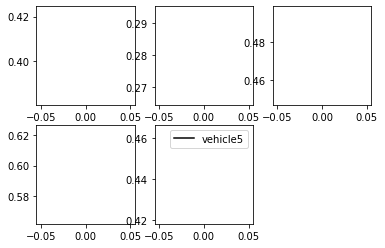

In [34]:
plot2(SOC1_final_list,  SOC2_final_list,  SOC3_final_list,  SOC4_final_list,  SOC5_final_list)

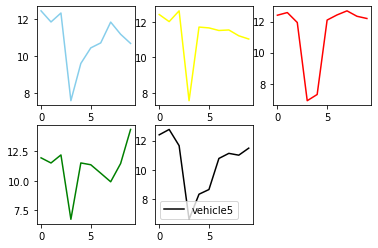

In [15]:
plot2(Total_fuel1_100Km_list,  Total_fuel2_100Km_list,  Total_fuel3_100Km_list,  Total_fuel4_100Km_list,  Total_fuel5_100Km_list)

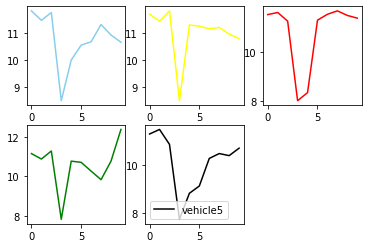

In [16]:
plot2(Total_RMB1_list,  Total_RMB2_list,  Total_RMB3_list,  Total_RMB4_list,  Total_RMB5_list)

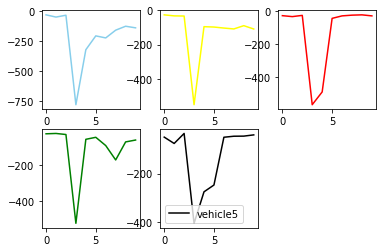

In [17]:
plot2(reward1_all_list,  reward2_all_list,  reward3_all_list,  reward4_all_list,  reward5_all_list)

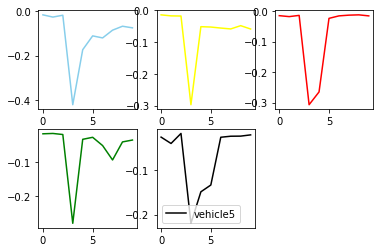

In [18]:
plot2(mean_reward1_list,  mean_reward2_list,  mean_reward3_list,  mean_reward4_list,  mean_reward5_list)

### 车辆

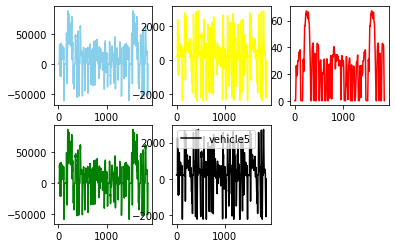

In [19]:
# 整车
plot2(P_axle1_list,  T_axle1_list,  W_axle1_list,   P_axle2_list,  T_axle2_list)

### 驱动电机

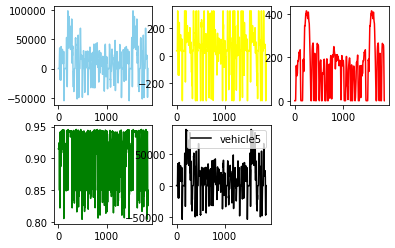

In [20]:
plot2(P_mot1_list,  T_mot1_list,  W_mot1_list,   eff_m1_list,  P_mot2_list)

### 发动机

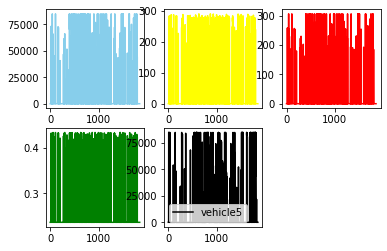

In [21]:
plot2(P_eng1_list,  T_eng1_list,  W_eng1_list,   eff_e1_list,  P_eng2_list)

### 发电机

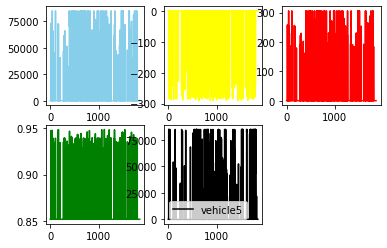

In [22]:
plot2(P_gen1_list,  T_gen1_list,  W_gen1_list,   eff_g1_list,  P_gen2_list)

### 电池

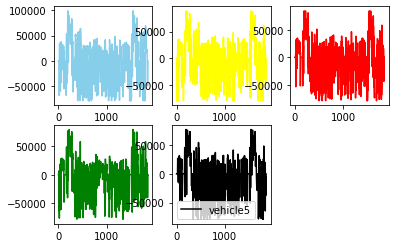

In [23]:
plot2(P_batt1_list,  P_batt2_list,  P_batt3_list,  P_batt4_list,  P_batt5_list)

### 油钱

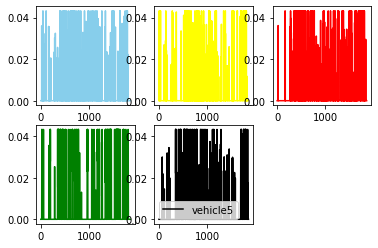

In [24]:
plot2(fuel1_list,  fuel2_list,  fuel3_list,  fuel4_list,  fuel5_list)

### 电钱

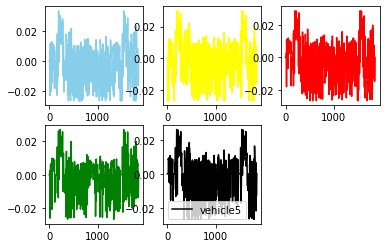

In [25]:
plot2(elec1_list,  elec2_list,  elec3_list,  elec4_list,  elec5_list)

### 总花费

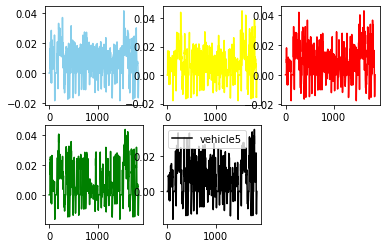

In [26]:
plot2(RMB_cost1_list,  RMB_cost2_list,  RMB_cost3_list,  RMB_cost4_list,  RMB_cost5_list)

## 6. Test the trained MADDPG agent

In [28]:
from MADDPG_agent import  Agent;  
agent = Agent(state_size, action_size, num_agents, random_seed)  

In [29]:
# Load the saved network weights
agent.actor_local.load_state_dict(torch.load('checkpoint_agent0_actor.pth', map_location='cpu'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic0_critic.pth', map_location='cpu'))
agent.actor_local.load_state_dict(torch.load('checkpoint_agent1_actor.pth', map_location='cpu'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic1_critic.pth', map_location='cpu'))

<All keys matched successfully>

In [30]:
# 一个循环最终SOC
SOC1_final_list=[]; SOC2_final_list=[]; SOC3_final_list=[]; SOC4_final_list=[]; SOC5_final_list=[];
# 一个循环油钱
Total_fuel_RMB1_list=[]; Total_fuel_RMB2_list=[]; Total_fuel_RMB3_list=[]; Total_fuel_RMB4_list=[]; Total_fuel_RMB5_list=[]; 
# 一个循环电钱
Total_elec_RMB1_list=[]; Total_elec_RMB2_list=[]; Total_elec_RMB3_list=[]; Total_elec_RMB4_list=[]; Total_elec_RMB5_list=[]; 
# 一个循环花钱
Total_RMB1_list=[]; Total_RMB2_list=[]; Total_RMB3_list=[]; Total_RMB4_list=[]; Total_RMB5_list=[];        
# 百公里燃油消耗
Total_fuel1_100Km_list=[]; Total_fuel2_100Km_list=[]; Total_fuel3_100Km_list=[]; Total_fuel4_100Km_list=[]; Total_fuel5_100Km_list=[]; 
# 一个循环奖励
reward1_all_list=[]; reward2_all_list=[]; reward3_all_list=[]; reward4_all_list=[]; reward5_all_list=[];
# 平均奖励
mean_reward1_list=[]; mean_reward2_list=[]; mean_reward3_list=[]; mean_reward4_list=[]; mean_reward5_list=[]; 
# 偶数循环平均奖励
list_even1=[]; list_even2=[]; list_even3=[]; list_even4=[]; list_even5=[];  
# 奇数循环平均奖励
list_odd1=[]; list_odd2=[]; list_odd3=[]; list_odd4=[]; list_odd5=[]; 
# 平均奖励递减
mean_discrepancy1_list=[]; mean_discrepancy2_list=[]; mean_discrepancy3_list=[]; mean_discrepancy4_list=[]; mean_discrepancy5_list=[]; 

In [31]:
n_episodes = 1

100%|████████████████████████████████████████████████████████████████████████████▉| 1851/1853 [00:15<00:00, 121.83it/s]

循环次数: 1
燃油消耗L (1.8130453566663227, 1.5728249853352436, 1.8030781521580814, 1.8831615462620408, 1.6348581339138921): 百公里燃油消耗L ([12.24786214341478], [10.625075387813247], [12.180529604643313], [12.721525651628898], [11.04413465145476]): 最终SOC (0.40242484695118386, 0.2798492768049393, 0.4729876015713786, 0.5941293082675727, 0.44233318803850924):


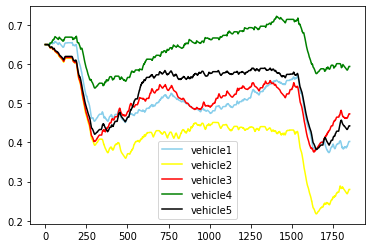

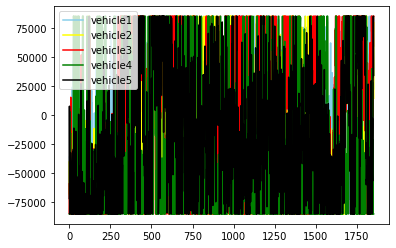

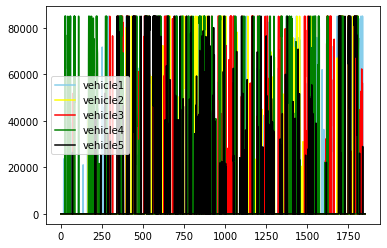

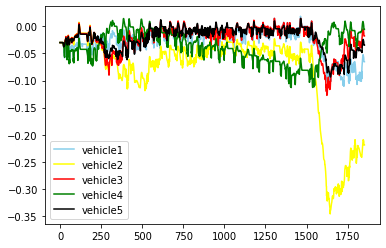

100%|█████████████████████████████████████████████████████████████████████████████| 1853/1853 [00:16<00:00, 110.00it/s]


In [32]:
for i_episode in range(1, n_episodes+1):
    # 状态输入
    SOC1 = SOC_origin; SOC2 = SOC_origin; SOC3 = SOC_origin; SOC4 = SOC_origin; SOC5 = SOC_origin; 
    T1 = Torque1[0];  T2 = Torque2[0];  T3 = Torque3[0];T4 = Torque4[0];  T5 = Torque5[0]; 
    V1 = Velocity1[0]; V2 = Velocity2[0]; V3 = Velocity3[0]; V4 = Velocity4[0]; V5 = Velocity5[0];

    # 状态空间 v、T、SOC
    V = np.vstack((V1, V2, V3, V4, V5));
    T = np.vstack((T1, T2, T3, T4, T5));
    SOC = np.vstack((SOC1,SOC2,SOC3,SOC4,SOC5));
    states = np.concatenate((V,  T,  SOC),axis=1)   

    # 车辆
    P_axle1 = 0;   T_axle1 = 0;   W_axle1 = 0;   P_axle1_list = [];   T_axle1_list = [];   W_axle1_list = [];
    P_axle2 = 0;   T_axle2 = 0;   W_axle2 = 0;   P_axle2_list = [];   T_axle2_list = [];   W_axle2_list = [];
    P_axle3 = 0;   T_axle3 = 0;   W_axle3 = 0;   P_axle3_list = [];   T_axle3_list = [];   W_axle3_list = [];
    P_axle4 = 0;   T_axle4 = 0;   W_axle4 = 0;   P_axle4_list = [];   T_axle4_list = [];   W_axle4_list = [];
    P_axle5 = 0;   T_axle5 = 0;   W_axle5 = 0;   P_axle5_list = [];   T_axle5_list = [];   W_axle5_list = [];
    # 驱动电机
    P_mot1 = 0; P_mot1_list = []; T_mot1 = 0; T_mot1_list = []; W_mot1 = 0; W_mot1_list = []; eff_m1 = 0; eff_m1_list = [];
    P_mot2 = 0; P_mot2_list = []; T_mot2 = 0; T_mot2_list = []; W_mot2 = 0; W_mot2_list = []; eff_m2 = 0; eff_m2_list = [];
    P_mot3 = 0; P_mot3_list = []; T_mot3 = 0; T_mot3_list = []; W_mot3 = 0; W_mot3_list = []; eff_m3 = 0; eff_m3_list = [];
    P_mot4 = 0; P_mot4_list = []; T_mot4 = 0; T_mot4_list = []; W_mot4 = 0; W_mot4_list = []; eff_m4 = 0; eff_m4_list = [];
    P_mot5 = 0; P_mot5_list = []; T_mot5 = 0; T_mot5_list = []; W_mot5 = 0; W_mot5_list = []; eff_m5 = 0; eff_m5_list = [];
    # 发动机
    P_eng1 = 0; P_eng1_list = []; T_eng1 = 0; T_eng1_list = []; W_eng1 = 0; W_eng1_list = []; eff_e1 = 0; eff_e1_list = [];
    P_eng2 = 0; P_eng2_list = []; T_eng2 = 0; T_eng2_list = []; W_eng2 = 0; W_eng2_list = []; eff_e2 = 0; eff_e2_list = [];
    P_eng3 = 0; P_eng3_list = []; T_eng3 = 0; T_eng3_list = []; W_eng3 = 0; W_eng3_list = []; eff_e3 = 0; eff_e3_list = [];
    P_eng4 = 0; P_eng4_list = []; T_eng4 = 0; T_eng4_list = []; W_eng4 = 0; W_eng4_list = []; eff_e4 = 0; eff_e4_list = [];
    P_eng5 = 0; P_eng5_list = []; T_eng5 = 0; T_eng5_list = []; W_eng5 = 0; W_eng5_list = []; eff_e5 = 0; eff_e5_list = [];
    # 发电机
    P_gen1 = 0; P_gen1_list = []; T_gen1 = 0; T_gen1_list = []; W_gen1 = 0; W_gen1_list = []; eff_g1 = 0; eff_g1_list = [];
    P_gen2 = 0; P_gen2_list = []; T_gen2 = 0; T_gen2_list = []; W_gen2 = 0; W_gen2_list = []; eff_g2 = 0; eff_g2_list = [];
    P_gen3 = 0; P_gen3_list = []; T_gen3 = 0; T_gen3_list = []; W_gen3 = 0; W_gen3_list = []; eff_g3 = 0; eff_g3_list = [];
    P_gen4 = 0; P_gen4_list = []; T_gen4 = 0; T_gen4_list = []; W_gen4 = 0; W_gen4_list = []; eff_g4 = 0; eff_g4_list = [];
    P_gen5 = 0; P_gen5_list = []; T_gen5 = 0; T_gen5_list = []; W_gen5 = 0; W_gen5_list = []; eff_g5 = 0; eff_g5_list = [];
    # 电池
    SOC1_data = [];    P_batt1 = 0;   P_batt1_list = [];
    SOC2_data = [];    P_batt2 = 0;   P_batt2_list = [];
    SOC3_data = [];    P_batt3 = 0;   P_batt3_list = [];
    SOC4_data = [];    P_batt4 = 0;   P_batt4_list = [];
    SOC5_data = [];    P_batt5 = 0;   P_batt5_list = [];
    
    # 动作 
    a1 = 0; a1_list = []; act1 = 0; act1_list = []; action1 = 0; action1_list = []; Eng_pwr_opt1 = 0; Eng_pwr_opt1_list = [];   
    a2 = 0; a2_list = []; act2 = 0; act2_list = []; action2 = 0; action2_list = []; Eng_pwr_opt2 = 0; Eng_pwr_opt2_list = [];   
    a3 = 0; a3_list = []; act3 = 0; act3_list = []; action3 = 0; action3_list = []; Eng_pwr_opt3 = 0; Eng_pwr_opt3_list = [];   
    a4 = 0; a4_list = []; act4 = 0; act4_list = []; action4 = 0; action4_list = []; Eng_pwr_opt4 = 0; Eng_pwr_opt4_list = [];   
    a5 = 0; a5_list = []; act5 = 0; act5_list = []; action5 = 0; action5_list = []; Eng_pwr_opt5 = 0; Eng_pwr_opt5_list = [];   
    # 奖励
    mean_reward1 = 0;  mean_reward2 = 0;   mean_reward3 = 0; mean_reward4 = 0;   mean_reward5 = 0;   
    ep_reward1_all = 0;  ep_reward2_all = 0;  ep_reward3_all = 0;  ep_reward4_all = 0;  ep_reward5_all = 0;  
    r1_list = [];  r2_list = [];  r3_list = [];  r4_list = [];  r5_list = [];  

    # 钱
    fuel1 = 0;   fuel1_list=[];   Total_fuel1_RMB = 0;   elec1 = 0;   elec1_list=[];   Total_elec1_RMB = 0;
    Total_RMB_cost1 = 0;   RMB_cost1_list = [];   RMB_cost1 = 0;   Total_fuel1  = 0;  
    fuel2 = 0;   fuel2_list=[];   Total_fuel2_RMB = 0;   elec2 = 0;   elec2_list=[];   Total_elec2_RMB = 0;
    Total_RMB_cost2 = 0;   RMB_cost2_list = [];   RMB_cost2 = 0;   Total_fuel2  = 0;  
    fuel3 = 0;   fuel3_list=[];   Total_fuel3_RMB = 0;   elec3 = 0;   elec3_list=[];   Total_elec3_RMB = 0;
    Total_RMB_cost3 = 0;   RMB_cost3_list = [];   RMB_cost3 = 0;   Total_fuel3  = 0;  
    fuel4 = 0;   fuel4_list=[];   Total_fuel4_RMB = 0;   elec4 = 0;   elec4_list=[];   Total_elec4_RMB = 0;
    Total_RMB_cost4 = 0;   RMB_cost4_list = [];   RMB_cost4 = 0;   Total_fuel4  = 0;  
    fuel5 = 0;   fuel5_list=[];   Total_fuel5_RMB = 0;   elec5 = 0;   elec5_list=[];   Total_elec5_RMB = 0;
    Total_RMB_cost5 = 0;   RMB_cost5_list = [];   RMB_cost5 = 0;   Total_fuel5  = 0;  
    
    Total_fuel = ();  Total_fuel_100Km = ();  SOC_final = ();  Eng_pwr_opt_max = 85000;
    step_episode += 1;      dones = [False, False, False, False, False] ;  not_done = 1

    for t in tqdm(range(len(Velocity1) - 1)): 

        # 选择动作
        actions = maddpg.act(states, i_episode, add_noise=True);  
        action1 = actions[0]; action2 = actions[1]; action3 = actions[2]; action4 = actions[3]; action5 = actions[4];
        # 动作列表
        action1_list.append(action1); action2_list.append(action2); action3_list.append(action3);  
        action4_list.append(action4); action5_list.append(action5);  
        # 发动机工作点
        Eng_pwr_opt1 = action1 * Eng_pwr_opt_max; Eng_pwr_opt2 = action2 * Eng_pwr_opt_max; Eng_pwr_opt3 = action3 * Eng_pwr_opt_max;
        Eng_pwr_opt4 = action4 * Eng_pwr_opt_max; Eng_pwr_opt5 = action5 * Eng_pwr_opt_max;   
        # 发动机工作点列表
        Eng_pwr_opt1_list.append(Eng_pwr_opt1); Eng_pwr_opt2_list.append(Eng_pwr_opt2); Eng_pwr_opt3_list.append(Eng_pwr_opt3);  
        Eng_pwr_opt4_list.append(Eng_pwr_opt4); Eng_pwr_opt5_list.append(Eng_pwr_opt5);  

        # 动作输入环境
        out1, RMB_cost1, soc1 = EREV.run(V1, T1, Eng_pwr_opt1, SOC1);
        out2, RMB_cost2, soc2 = EREV.run(V2, T2, Eng_pwr_opt2, SOC2);
        out3, RMB_cost3, soc3 = EREV.run(V3, T3, Eng_pwr_opt3, SOC3);
        out4, RMB_cost4, soc4 = EREV.run(V4, T4, Eng_pwr_opt4, SOC4);
        out5, RMB_cost5, soc5 = EREV.run(V5, T5, Eng_pwr_opt5, SOC5);
        
        # 整车
        P_axle1_list.append(float(out1['P_axle']));T_axle1_list.append(float(out1['T_axle']));W_axle1_list.append(float(out1['W_axle']));  
        P_axle2_list.append(float(out2['P_axle']));T_axle2_list.append(float(out2['T_axle']));W_axle2_list.append(float(out2['W_axle']));  
        P_axle3_list.append(float(out3['P_axle']));T_axle3_list.append(float(out3['T_axle']));W_axle3_list.append(float(out3['W_axle'])); 
        P_axle4_list.append(float(out4['P_axle']));T_axle4_list.append(float(out4['T_axle']));W_axle4_list.append(float(out4['W_axle']));  
        P_axle5_list.append(float(out5['P_axle']));T_axle5_list.append(float(out5['T_axle']));W_axle5_list.append(float(out5['W_axle'])); 
        # 驱动电机
        P_mot1_list.append(float(out1['P_mot']));  T_mot1_list.append( float(out1['T_mot'])); W_mot1_list.append(float(out1['W_mot']));
        eff_m1_list.append(float(out1['eff_m']));  
        P_mot2_list.append(float(out2['P_mot']));  T_mot2_list.append( float(out2['T_mot'])); W_mot2_list.append(float(out2['W_mot']));
        eff_m2_list.append(float(out2['eff_m']));  
        P_mot3_list.append(float(out3['P_mot']));  T_mot3_list.append( float(out3['T_mot'])); W_mot3_list.append(float(out3['W_mot']));
        eff_m3_list.append(float(out3['eff_m']));  
        P_mot4_list.append(float(out4['P_mot']));  T_mot4_list.append( float(out4['T_mot'])); W_mot4_list.append(float(out4['W_mot']));
        eff_m4_list.append(float(out4['eff_m']));  
        P_mot5_list.append(float(out5['P_mot']));  T_mot5_list.append( float(out5['T_mot'])); W_mot5_list.append(float(out5['W_mot']));
        eff_m5_list.append(float(out5['eff_m']));  
        # 发动机
        P_eng1_list.append(float(out1['P_eng'])); T_eng1_list.append(float(out1['T_eng']));W_eng1_list.append(float(out1['W_eng']));
        eff_e1_list.append(float(out1['eff_e']));
        P_eng2_list.append(float(out2['P_eng'])); T_eng2_list.append(float(out2['T_eng']));W_eng2_list.append(float(out2['W_eng']));
        eff_e2_list.append(float(out2['eff_e']));
        P_eng3_list.append(float(out3['P_eng'])); T_eng3_list.append(float(out3['T_eng']));W_eng3_list.append(float(out3['W_eng'])); 
        eff_e3_list.append(float(out3['eff_e']));
        P_eng4_list.append(float(out4['P_eng'])); T_eng4_list.append(float(out4['T_eng']));W_eng4_list.append(float(out4['W_eng']));
        eff_e4_list.append(float(out4['eff_e']));
        P_eng5_list.append(float(out5['P_eng'])); T_eng5_list.append(float(out5['T_eng']));W_eng5_list.append(float(out5['W_eng']));
        eff_e5_list.append(float(out5['eff_e']));
        # 发电机
        P_gen1_list.append(float(out1['P_eng'])); T_gen1_list.append(float(out1['T_gen'])); W_gen1_list.append(float(out1['W_gen']));
        eff_g1_list.append(float(out1['eff_g'])); 
        P_gen2_list.append(float(out2['P_eng'])); T_gen2_list.append(float(out2['T_gen'])); W_gen2_list.append(float(out2['W_gen']));
        eff_g2_list.append(float(out2['eff_g']));         
        P_gen3_list.append(float(out3['P_eng'])); T_gen3_list.append(float(out3['T_gen'])); W_gen3_list.append(float(out3['W_gen']));
        eff_g3_list.append(float(out3['eff_g']));       
        P_gen4_list.append(float(out4['P_eng'])); T_gen4_list.append(float(out4['T_gen'])); W_gen4_list.append(float(out4['W_gen']));
        eff_g4_list.append(float(out4['eff_g']));     
        P_gen5_list.append(float(out5['P_eng'])); T_gen5_list.append(float(out5['T_gen'])); W_gen5_list.append(float(out5['W_gen']));
        eff_g5_list.append(float(out5['eff_g']));     
        # 油钱、电钱、总花费
        fuel1 = float(out1['price_fuel']); fuel1_list.append(fuel1); Total_fuel1_RMB += fuel1;
        elec1 = float(out1['price_elec']); elec1_list.append(elec1); Total_elec1_RMB += elec1; 
        RMB_cost1 = float(RMB_cost1); RMB_cost1_list.append(RMB_cost1); Total_RMB_cost1 += RMB_cost1;   
        fuel2 = float(out2['price_fuel']); fuel2_list.append(fuel2); Total_fuel2_RMB += fuel2;
        elec2 = float(out2['price_elec']); elec2_list.append(elec2); Total_elec2_RMB += elec2; 
        RMB_cost2 = float(RMB_cost2); RMB_cost2_list.append(RMB_cost2); Total_RMB_cost2 += RMB_cost2;           
        fuel3 = float(out3['price_fuel']); fuel3_list.append(fuel3); Total_fuel3_RMB += fuel3;
        elec3 = float(out3['price_elec']); elec3_list.append(elec3); Total_elec3_RMB += elec3; 
        RMB_cost3 = float(RMB_cost3); RMB_cost3_list.append(RMB_cost3); Total_RMB_cost3 += RMB_cost3;     
        fuel4 = float(out4['price_fuel']); fuel4_list.append(fuel4); Total_fuel4_RMB += fuel4;
        elec4 = float(out4['price_elec']); elec4_list.append(elec4); Total_elec4_RMB += elec4; 
        RMB_cost4 = float(RMB_cost4); RMB_cost4_list.append(RMB_cost4); Total_RMB_cost4 += RMB_cost4;   
        fuel5 = float(out5['price_fuel']); fuel5_list.append(fuel5); Total_fuel5_RMB += fuel5;
        elec5 = float(out5['price_elec']); elec5_list.append(elec5); Total_elec5_RMB += elec5; 
        RMB_cost5 = float(RMB_cost5); RMB_cost5_list.append(RMB_cost5); Total_RMB_cost5 += RMB_cost5;   
        # 电池
        P_batt1_list.append(float(out1['P_batt']));P_batt2_list.append(float(out2['P_batt']));P_batt3_list.append(float(out3['P_batt']));
        P_batt4_list.append(float(out4['P_batt']));P_batt5_list.append(float(out5['P_batt']));  

        # get next state
        SOC1 = float(soc1);  SOC1_data.append(SOC1); SOC2 = float(soc2);  SOC2_data.append(SOC2);   
        SOC3 = float(soc3);  SOC3_data.append(SOC3); SOC4 = float(soc4);  SOC4_data.append(SOC4);  
        SOC5 = float(soc5);  SOC5_data.append(SOC5);  
        T1 = Torque1[t+1];   T2 = Torque2[t+1];   T3 = Torque3[t+1];  T4 = Torque4[t+1];  T5 = Torque5[t+1];  
        V1 = Velocity1[t + 1];   V2 = Velocity2[t + 1]; V3 = Velocity3[t + 1]; V4 = Velocity4[t + 1]; V5 = Velocity5[t + 1]; 
        V = np.vstack((V1,V2,V3,V4,V5)); T = np.vstack((T1,T2,T3,T4,T5)); SOC = np.vstack((SOC1,SOC2,SOC3,SOC4,SOC5));  
        next_states = np.concatenate((V, T, SOC),axis=1);

        # get reward
        r1 = (-RMB_cost1 - 3 * (0.55 - SOC1)**2);r2 = (-RMB_cost2 - 3 * (0.55 - SOC2)**2);r3 = (-RMB_cost3 - 3 * (0.55 - SOC3)**2);
        r4 = (-RMB_cost4 - 3 * (0.55 - SOC4)**2);r5 = (-RMB_cost5 - 3 * (0.55 - SOC5)**2)
        r1_list.append(r1);  r2_list.append(r2);  r3_list.append(r3);  r4_list.append(r4);  r5_list.append(r5);  
        ep_reward1_all += r1;  ep_reward2_all += r2;  ep_reward3_all += r3;  ep_reward4_all += r4;  ep_reward5_all += r5;  
        rewards = np.vstack((r1,  r2,  r3,  r4,  r5))   
        
        # roll over state to next time step
        states = next_states       
        
        # see if episode finished
        if t == (len(Velocity1) - 2):
            # 一个循环的最终SOC
            SOC1_final_list.append(SOC1); SOC2_final_list.append(SOC2); SOC3_final_list.append(SOC3);
            SOC4_final_list.append(SOC4); SOC5_final_list.append(SOC5); 
            SOC_final = (SOC1,SOC2,SOC3,SOC4,SOC5)
            # 一个循环油钱
            Total_fuel_RMB1_list.append(Total_fuel1_RMB); Total_fuel_RMB2_list.append(Total_fuel2_RMB);
            Total_fuel_RMB3_list.append(Total_fuel3_RMB); Total_fuel_RMB4_list.append(Total_fuel4_RMB);
            Total_fuel_RMB5_list.append(Total_fuel5_RMB);
            # 一个循环电钱 
            Total_elec_RMB1_list.append(Total_elec1_RMB); Total_elec_RMB2_list.append(Total_elec2_RMB);
            Total_elec_RMB3_list.append(Total_elec3_RMB); Total_elec_RMB4_list.append(Total_elec4_RMB);
            Total_elec_RMB5_list.append(Total_elec5_RMB);

            # 一个循环耗油
            Total_fuel1 = Total_fuel1_RMB / 6.5;  Total_fuel2 = Total_fuel2_RMB / 6.5;  Total_fuel3 = Total_fuel3_RMB / 6.5;  
            Total_fuel4 = Total_fuel4_RMB / 6.5;  Total_fuel5 = Total_fuel5_RMB / 6.5;  
            Total1_fuel = Total_fuel1 + (SOC1 < SOC_origin) * (SOC_origin - SOC1) * (350*25) * 3600 /(42600000) / 0.72;
            Total2_fuel = Total_fuel2 + (SOC2 < SOC_origin) * (SOC_origin - SOC2) * (350*25) * 3600 /(42600000) / 0.72;
            Total3_fuel = Total_fuel3 + (SOC3 < SOC_origin) * (SOC_origin - SOC3) * (350*25) * 3600 /(42600000) / 0.72;
            Total4_fuel = Total_fuel4 + (SOC4 < SOC_origin) * (SOC_origin - SOC4) * (350*25) * 3600 /(42600000) / 0.72;
            Total5_fuel = Total_fuel5 + (SOC5 < SOC_origin) * (SOC_origin - SOC5) * (350*25) * 3600 /(42600000) / 0.72;

            # 百公里燃油消耗
            Total_fuel1_100Km_list.append(Total1_fuel * (100 / total_milage));
            Total_fuel2_100Km_list.append(Total2_fuel * (100 / total_milage));
            Total_fuel3_100Km_list.append(Total3_fuel * (100 / total_milage));
            Total_fuel4_100Km_list.append(Total4_fuel * (100 / total_milage));
            Total_fuel5_100Km_list.append(Total5_fuel * (100 / total_milage));
            # 输出
            Total_fuel = (Total1_fuel,Total2_fuel,Total3_fuel,Total4_fuel,Total5_fuel);
            Total_fuel_100Km=(Total_fuel1_100Km_list,Total_fuel2_100Km_list,Total_fuel3_100Km_list,
                              Total_fuel4_100Km_list,Total_fuel5_100Km_list);

            # 一个循环花钱
            Total_RMB1_list.append(Total_RMB_cost1);Total_RMB2_list.append(Total_RMB_cost2);Total_RMB3_list.append(Total_RMB_cost3);
            Total_RMB4_list.append(Total_RMB_cost4);Total_RMB5_list.append(Total_RMB_cost5);
            # 一个循环奖励
            reward1_all_list.append(ep_reward1_all);reward2_all_list.append(ep_reward2_all);reward3_all_list.append(ep_reward3_all);
            reward4_all_list.append(ep_reward4_all);reward5_all_list.append(ep_reward5_all);
            mean_reward1= ep_reward1_all / (len(Velocity1) - 2); mean_reward2= ep_reward2_all / (len(Velocity1) - 2); 
            mean_reward3= ep_reward3_all / (len(Velocity1) - 2); mean_reward4= ep_reward4_all / (len(Velocity1) - 2); 
            mean_reward5= ep_reward5_all / (len(Velocity1) - 2); 
            mean_reward1_list.append(mean_reward1); mean_reward2_list.append(mean_reward2); mean_reward3_list.append(mean_reward3);  
            mean_reward4_list.append(mean_reward4); mean_reward5_list.append(mean_reward5);  
            
            # 查看回合是否结束
            dones = [True,True,True,True,True] ;   

            print('循环次数:', i_episode)
            print('燃油消耗L {}: 百公里燃油消耗L {}: 最终SOC {}:'.format(Total_fuel, Total_fuel_100Km, SOC_final ))
            plot1(SOC1_data, SOC2_data, SOC3_data, SOC4_data, SOC5_data)
            plot1(Eng_pwr_opt1_list, Eng_pwr_opt2_list, Eng_pwr_opt3_list, Eng_pwr_opt4_list, Eng_pwr_opt5_list) # 发动机工作点输入
            plot1(P_eng1_list, P_eng2_list, P_eng3_list, P_eng4_list, P_eng5_list) # 发动机工作点
            plot1(r1_list, r2_list, r3_list, r4_list, r5_list) # 每个奖励
            
        else:
            dones = [False, False, False, False, False]        